In [50]:
import os
import time
import json
import numpy as np 
import pandas as pd  
import itertools  
from collections import Counter  
import matplotlib.pyplot as plt 
from sklearn.metrics import (accuracy_score,roc_auc_score,confusion_matrix,classification_report,f1_score) 
from datasets import Dataset, Image, ClassLabel
# from transformers import ( TrainingArguments,Trainer,ViTImageProcessor,ViTForImageClassification,DefaultDataCollator)
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision
from torch import optim 
from torch.optim import lr_scheduler 
from torchvision import models 
from torchvision import transforms 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
from torch.utils.data import DataLoader  
from torchvision.transforms import ( CenterCrop,Compose,Normalize,RandomRotation,RandomResizedCrop,RandomHorizontalFlip,RandomAdjustSharpness,Resize,ToTensor )
import warnings  
warnings.filterwarnings("ignore")  

## Data integration

In [51]:
# NV - 0 MEL - 1 BCC - 2 BKL - 3 AK - 4 SCC - 5 VASC - 6 DF - 7
mapping = {
    "NV": 0,
    "MEL": 1,
    "BCC": 2,
    "BKL": 3,
    "AK": 4,
    "SCC": 5,
    "VASC": 6,
    "DF": 7
}


In [52]:
def createDF(image_dir):
    image_paths = []
    labels = []
    for root, dirs, files in os.walk(image_dir):
        for file in files:
            path=os.path.join(root,file)
            if os.path.isfile(path):
                image_paths.append(path)
                labels.append(mapping[root.split('/')[-1]])
                
    return pd.DataFrame.from_dict({"image": image_paths, "label": labels})
#             if file.endswith(".png"):  # Adjust the file extension as needed
#                 image_paths.append(os.path.join(root, file))
#                 labels.append(root.split("/")[-1])  # Extract the class label from the folder structure

In [53]:
train_df = createDF("/kaggle/input/dermoscopic-images/ISIC84by84/Train")
test_df = createDF("/kaggle/input/dermoscopic-images/ISIC84by84/Test")

## Class Distribution

In [54]:
def class_distribution(train, test):
    # Calculate class frequencies
    train_class_counts = train['label'].value_counts()

    test_class_counts = test['label'].value_counts()

    # Plotting class distribution for train and test sets side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    train_class_counts.plot(kind='bar', color='skyblue', ax=ax1)
    ax1.set_title('Train Set Class Distribution')
    ax1.set_xlabel('Class Label')
    ax1.set_ylabel('Count')

    test_class_counts.plot(kind='bar', color='salmon', ax=ax2)
    ax2.set_title('Test Set Class Distribution')
    ax2.set_xlabel('Class Label')
    ax2.set_ylabel('Count')

    plt.tight_layout()
    plt.show()

In [55]:
train_class_counts = train_df['label'].value_counts()
print(train_class_counts)

label
0    12775
1     4422
2     3223
3     2524
4      735
5      528
6      153
7      139
Name: count, dtype: int64


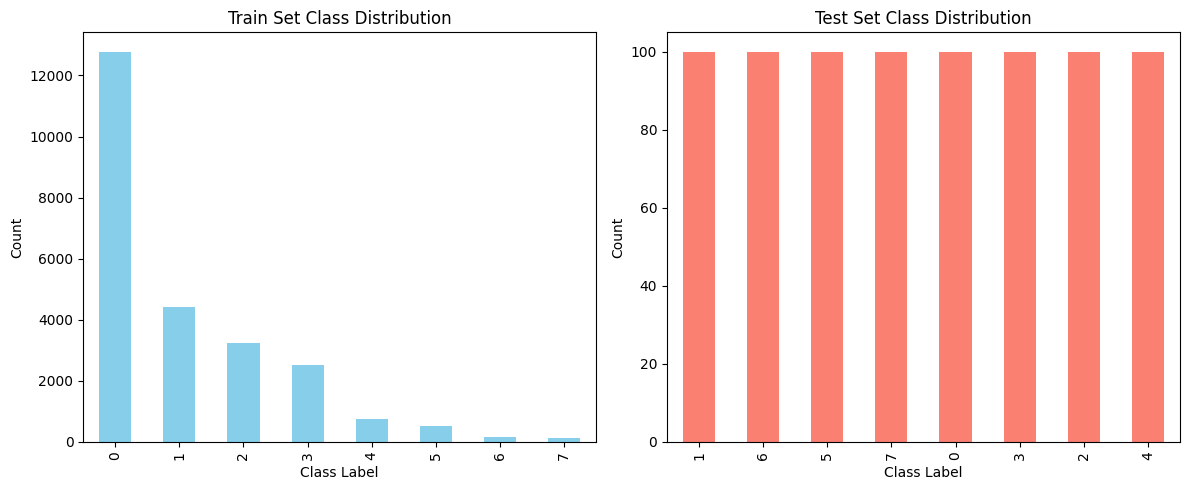

In [56]:
class_distribution(train_df, test_df)

#### Mapping

NV -  0
MEL - 1
BCC - 2
BKL - 3
AK - 4
SCC - 5
VASC - 6
DF - 7

### Downsample

In [57]:
random_seed = 42

# Filter the DataFrame to separate label 0 and other labels
label_0_df = train_df[train_df['label'] == 0]
other_labels_df = train_df[train_df['label'] != 0]

# Sample 8000 entries from the label 0 DataFrame
sampled_label_0_df = label_0_df.sample(n=8000, random_state=random_seed)

# Concatenate the sampled label 0 DataFrame with the DataFrame of other labels
balanced_train_df = pd.concat([sampled_label_0_df, other_labels_df])

# Optionally, shuffle the DataFrame if needed to mix the rows up
balanced_train_df = balanced_train_df.sample(frac=1, random_state=random_seed).reset_index(drop=True)
train_df = balanced_train_df
# Now 'balanced_train_df' is your new DataFrame with label 0 reduced to 8000 samples

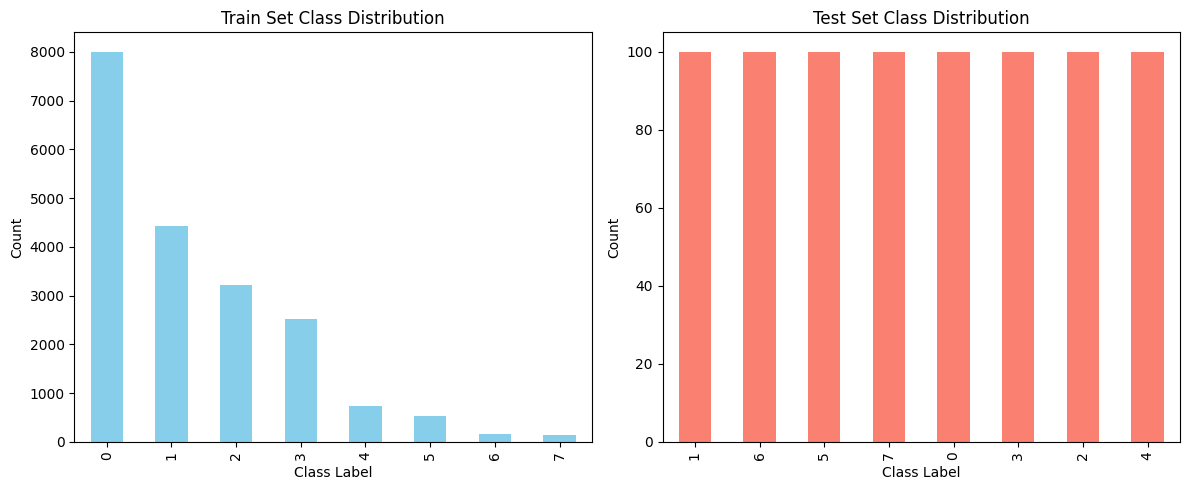

In [58]:
class_distribution(balanced_train_df, test_df)

### Upsampling(SMOTE）

In [59]:
from imblearn.over_sampling import SMOTE

In [60]:
from sklearn.utils import shuffle


def load_images(dataframe):
    images = []
    labels = []
#     size_count = {}  # Dictionary to track the count of each image size

    for idx, row in dataframe.iterrows():
#         image = cv2.imread(row['image'], cv2.IMREAD_COLOR)
        image = Image.open(row['image'])
        image = image.convert('RGB')
        if image is not None:
#             image_size = image.shape
            
#             # Update the size_count dictionary
#             if image_size in size_count:
#                 size_count[image_size] += 1
#             else:
#                 size_count[image_size] = 1

            image_array = np.array(image)
            
            images.append(image_array.flatten())
            labels.append(row['label'])

#     print("Image size counts:", size_count)
    return np.array(images), np.array(labels)


images, labels = load_images(train_df)


In [61]:
smote_scale = {4: 1.5, 5: 1.5, 6: 5, 7: 5}
smote_strategy = {}

for key,value in smote_scale.items():
    smote_strategy[key] = int(value*train_class_counts[key])

print(smote_strategy)

{4: 1102, 5: 792, 6: 765, 7: 695}


In [62]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=smote_strategy, random_state=42, k_neighbors=2)

# Resample the dataset

X_res, y_res = smote.fit_resample(images, labels)


from collections import Counter
class_counts = Counter(y_res)
print(class_counts)

Counter({0: 8000, 1: 4422, 2: 3223, 3: 2524, 4: 1102, 5: 792, 6: 765, 7: 695})


#### Calculate class weights

In [63]:

total_samples = sum(class_counts.values())
# Calculate and print the ratio total_number/number for each class
ratios = {class_id: total_samples / count for class_id, count in class_counts.items()}
print(ratios)
ratios_list = []
for i in range (8):
    ratios_list.append( ratios[i])
label_weights = np.array(ratios_list)
print(label_weights)
class_weights=torch.cuda.FloatTensor(label_weights.astype(np.float32))
print(class_weights)

{2: 6.67793980763264, 3: 8.527337559429476, 0: 2.690375, 1: 4.867254635911352, 4: 19.530852994555353, 5: 27.175505050505052, 7: 30.96834532374101, 6: 28.134640522875817}
[ 2.690375    4.86725464  6.67793981  8.52733756 19.53085299 27.17550505
 28.13464052 30.96834532]
tensor([ 2.6904,  4.8673,  6.6779,  8.5273, 19.5309, 27.1755, 28.1346, 30.9683],
       device='cuda:0')


In [64]:
# label_counts = train_df['label'].value_counts()

# total_samples = train_df.shape[0]

# label_frequencies = total_samples/label_counts 
# label_frequencies = label_frequencies.to_numpy()
# print(label_frequencies)

# class_weights=torch.cuda.FloatTensor(label_frequencies.astype(np.float32))

In [65]:
X_res_reshaped = X_res.reshape(-1, 84, 84, 3)  # Reshape back to original image dimensions
X_res_reshaped, y_res = shuffle(X_res_reshaped, y_res, random_state=42)

In [66]:
def validate_image(image):
    dtype = image.dtype
    min_val, max_val = np.min(image), np.max(image)
    
    is_uint8 = dtype == np.uint8
    in_range = min_val >= 0 and max_val <= 255
    
    print(f"Data Type is uint8: {is_uint8}")
    print(f"Values range from 0 to 255: {in_range}")
    
    if is_uint8 and in_range:
        print("Image is properly formatted for most image processing tasks.")
    else:
        print("Image might need conversion or scaling.")
    
    return is_uint8, in_range
validate_image(X_res_reshaped)

Data Type is uint8: True
Values range from 0 to 255: True
Image is properly formatted for most image processing tasks.


(True, True)

In [67]:
import os

In [68]:
import pandas as pd

# Flatten images if they are not already (since the original df likely used flattened images)
X_flattened = X_res_reshaped.reshape(X_res_reshaped.shape[0], -1)

# Create DataFrame from images and labels
new_train_df = pd.DataFrame(X_flattened)
new_train_df['label'] = y_res  # Add the labels column

# Optionally, give columns names corresponding to pixel indices and 'label'
pixel_columns = [f'pixel_{i}' for i in range(X_flattened.shape[1])]
new_train_df.columns = pixel_columns + ['label']
print(new_train_df)
train_df = new_train_df

       pixel_0  pixel_1  pixel_2  pixel_3  pixel_4  pixel_5  pixel_6  pixel_7  \
0           96       95       93      100       99       97      106      105   
1            0        0        0        0        0        0        0        0   
2          184      181      172      193      190      181      202      198   
3          150      120      126      157      127      133      163      133   
4          162      139      165      163      140      166      163      140   
...        ...      ...      ...      ...      ...      ...      ...      ...   
21518      235      164      170      235      164      170      235      164   
21519      185      169      182      187      171      184      190      174   
21520       95       72       30       96       73       31      105       82   
21521       32        0        0       64       29       27      120       82   
21522      168      156      132      174      162      138      174      164   

       pixel_8  pixel_9  ..

## Image Transform

In [69]:

train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224,224)),
    
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15, expand=False, fill=None),
    
    transforms.RandomAffine(degrees=0, translate=None, scale=(0.8, 1.2), shear=None, fill=0),
    transforms.RandomAffine(degrees=0,shear=10),    
    
    transforms.RandomApply([transforms.Grayscale(num_output_channels=3)], p=0.2),
    transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0)],p=0.1),
    transforms.RandomApply([transforms.GaussianBlur(11, 10)],p=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# from official  documentation
])

val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224,224)),
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# from official  documentation
])

no_transform = transforms.Compose([
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])# from official  documentation
])

## Dataset class & loader

In [70]:


# class CustomDataset(Dataset):
#     def __init__(self, img_data, transform=None):
#         self.transform = transform
#         self.img_data = img_data
        
#     def __len__(self):
#         return len(self.img_data)
    
#     def __getitem__(self, index):

#         image_data = self.img_data.iloc[index][:-1].values.astype(np.uint8)

#         image = image_data.reshape(84, 84, 3)
        
#         # Convert the numpy array to a PIL Image for compatibility with torchvision transforms
#         image = Image.fromarray(image, 'RGB')
        
#         # Retrieve the label
#         label = torch.tensor(self.img_data.iloc[index]['label'])

#         if self.transform:
#             image = self.transform(image)
#         else:
#             image = no_transform(image)
#         return image, label

In [71]:
from PIL import Image
class TrainDataset(Dataset):
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index, apply_transform=True):
        
#         image = Image.open(self.img_data.loc[index, 'image'])
#         image = image.convert('RGB')
        image_data = self.img_data.iloc[index][:-1].values.astype(np.uint8)
        image = image_data.reshape(84, 84, 3)
        image = Image.fromarray(image, 'RGB')
        
        # Retrieve the label
        label = torch.tensor(self.img_data.iloc[index]['label'])
        
        if self.transform is not None and apply_transform:
            new_image = self.transform(image)
        else:
            new_image = no_transform(image)
        return new_image, label


In [72]:
class TestDataset(Dataset):
    
    def __init__(self, img_data,transform=None):
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index, apply_transform=True):
        image = Image.open(self.img_data.loc[index, 'image'])
        image = image.convert('RGB')

        label = torch.tensor(self.img_data.loc[index, 'label'])
        if self.transform is not None and apply_transform:
            image = self.transform(image)
        else:
            image = no_transform(image)
        return image, label


In [73]:
train_dataset= TrainDataset(train_df, train_transform)
test_dataset = TestDataset(test_df, val_transform)

In [74]:
# data loader setting
batch_size = 64
shuffle_dataset = True

In [75]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle_dataset)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=shuffle_dataset)

In [76]:
import random

In [77]:
# train_dataset = TestDataset(train_df,val_transform)

9010


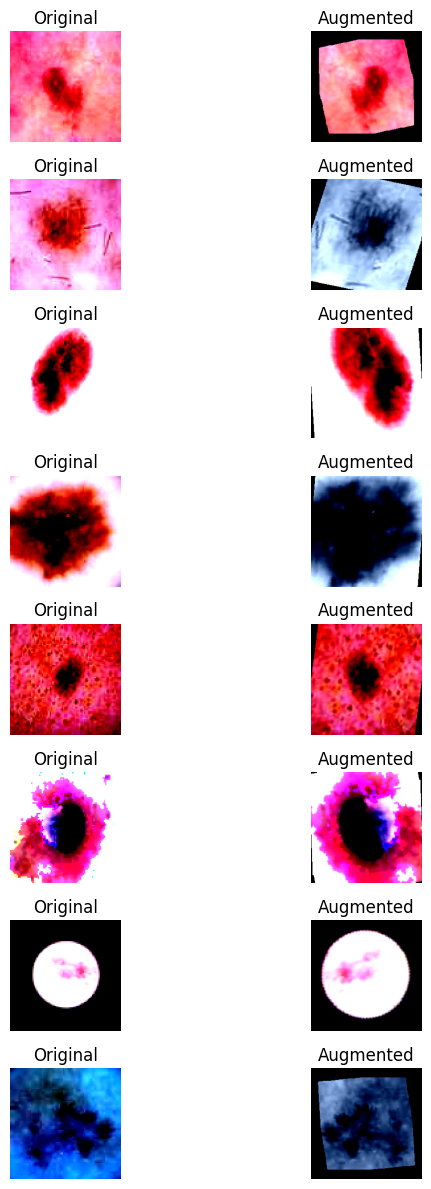

In [78]:
# Define a function to display original and augmented images
def display_augmented_images(dataset, num_samples=8, seed=None):
    
    if seed is None:
        seed = random.randint(0,10000)
        print(seed)
        
    np.random.seed(seed)
    
    fig, axes = plt.subplots(num_samples, 2, figsize=(8, 12))

    for i in range(num_samples):
        # Select a random sample
        index = np.random.randint(len(dataset))
        
        original_image, _ = dataset.__getitem__(index, apply_transform=False)
#         original_image = transforms.ToTensor()(original_image) 
        # Plot original image
        axes[i, 0].imshow(np.transpose(original_image.numpy(), (1, 2, 0)))
        axes[i, 0].set_title('Original')
        axes[i, 0].axis('off')

        # Plot augmented image
#         augmented_image = train_transform(original_image)
        augmented_image, _ = dataset.__getitem__(index, apply_transform=True)
        axes[i, 1].imshow(np.transpose(augmented_image.numpy(), (1, 2, 0)))
        axes[i, 1].set_title('Augmented')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Display original and augmented images
display_augmented_images(train_dataset)

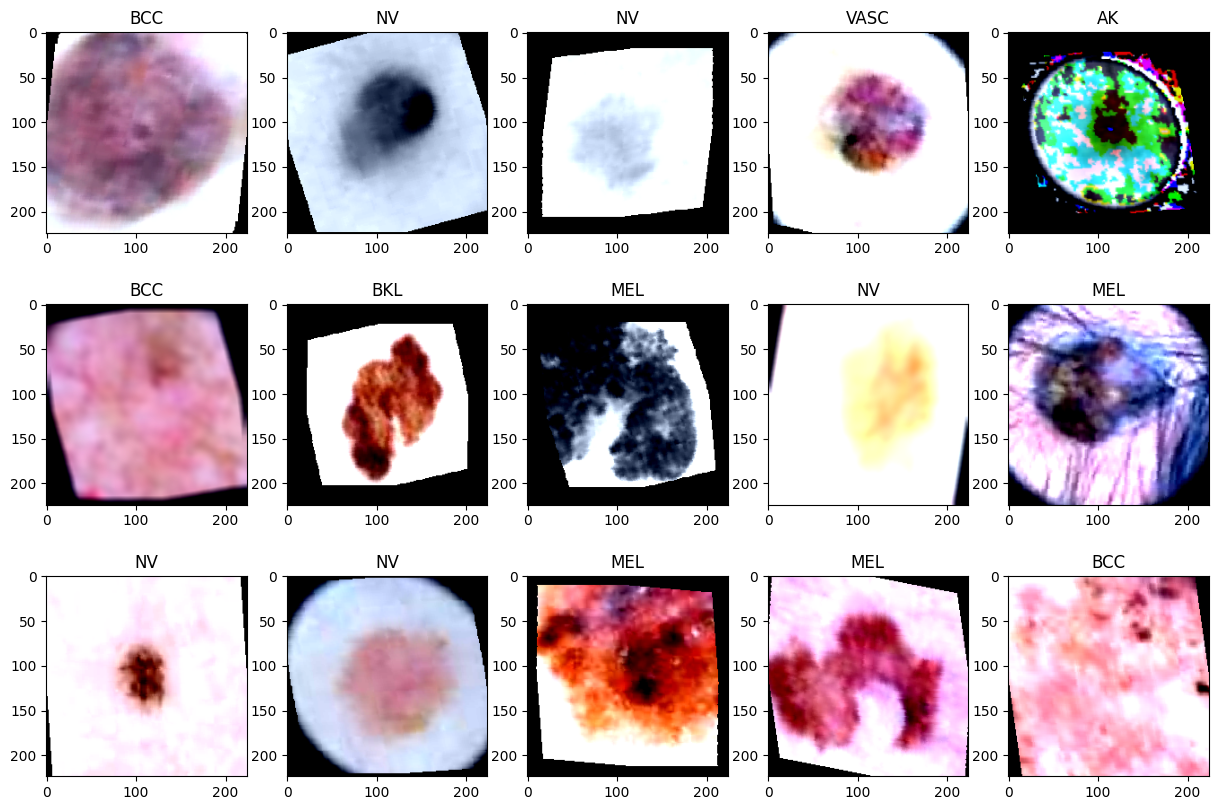

In [79]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

arthopod_types = {value: key for key, value in mapping.items()}
# for i in range(0,8):
#     arthopod_types[i]=mapping
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

## Train & Test functions

In [80]:
train_acc_history = []
val_acc_history = []
train_loss_history = []
val_loss_history = []

# Training function
def train_model(model, criterion, optimizer, scheduler,path_prefix,start_epoch=0, num_epochs=25, patience=100):
    best_model_wts = model.state_dict()
    best_acc = 0.0
    epochs_no_improve = 0


    for epoch in range(num_epochs):
        epoch += start_epoch
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
#             print(inputs.size(),labels.size())
#             print(labels)
            
            optimizer.zero_grad()

            outputs = model(inputs)
#             print(outputs.size())
#             print(outputs)
            
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            
        
        scheduler.step()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects.double() / len(train_loader.dataset)

        train_acc_history.append(epoch_acc.cpu().numpy().item())
        train_loss_history.append(epoch_loss)

        print(f'Train Epoch {epoch}/{start_epoch+num_epochs - 1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for val_inputs, val_labels in test_loader:
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)

                val_outputs = model(val_inputs)
                val_loss = criterion(val_outputs, val_labels)
                val_running_loss += val_loss.item()
                
                _, val_preds = torch.max(val_outputs, 1)
                
                val_running_corrects += torch.sum(val_preds == val_labels.data)

        val_epoch_loss = val_running_loss / len(test_loader.dataset)
        val_epoch_acc = val_running_corrects.double() / len(test_loader.dataset)

        val_acc_history.append(val_epoch_acc.cpu().numpy().item())
        val_loss_history.append(val_epoch_loss)

        print(f'Val Epoch {epoch}/{num_epochs+start_epoch - 1} Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')
        
        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print(f'Early stopping triggered after {patience} epochs of no improvement.')
                break
                
        torch.save(model.state_dict(),f"{path_prefix}_{epoch}.pt")

    model.load_state_dict(best_model_wts)
    
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history



## Define Models

In [81]:
class EfficientNetModel(nn.Module):
    def __init__(self,dropout_rate=0.3,mid_features=512):
        super(EfficientNetModel, self).__init__()
        self.model =  models.efficientnet_b0(pretrained=True)
        num_features = self.model.classifier[1].in_features
        
#         self.model.fc = nn.Sequential(
#             nn.Linear(self.model.classifier[1].in_features, mid_features),  # Additional layer for flexibility
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=dropout_rate),  #Drop out layer added
#             nn.Linear(mid_features, 8)  
#         )
        self.model.classifier = nn.Sequential(
            nn.Linear(num_features, mid_features),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(mid_features, 8)  # Outputs for 8 classes
        )
        print(self.model)
        
    def forward(self, x):
        return self.model(x)

## Parameters

In [82]:
#common parameters
epsilon = 1e-08

momentum = 0.9

criterion = nn.CrossEntropyLoss(weight=class_weights)
# criterion = nn.CrossEntropyLoss()

#final selection
learning_rate = 0.001
weight_decay = 1e-4
step_size = 5
gamma = 0.5

## Training

In [83]:
torch.cuda.empty_cache() 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [84]:
save_path = "/kaggle/working/efficientnet.pt"
efficientnet_model = EfficientNetModel().to(device)
efficientnet_model.load_state_dict(torch.load("/kaggle/input/efficientnet-weightedloss-resampling/efficientnet.pt_9.pt"))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

<All keys matched successfully>

In [85]:
optimizer = optim.Adam(efficientnet_model.parameters(), lr=learning_rate, eps=epsilon, weight_decay=weight_decay)
# optimizer_SGD = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay,momentum=0.9,nesterov=True)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [86]:
print(class_weights)

tensor([ 2.6904,  4.8673,  6.6779,  8.5273, 19.5309, 27.1755, 28.1346, 30.9683],
       device='cuda:0')


In [87]:
# Train models
efficientnet_model,train_acc_history, val_acc_history, train_loss_history, val_loss_history = train_model(efficientnet_model, criterion, optimizer, exp_lr_scheduler,"model",start_epoch=9, num_epochs=34)


Train Epoch 9/42 Loss: 0.0144 Acc: 0.6189
Val Epoch 9/42 Loss: 0.0184 Acc: 0.6250
Train Epoch 10/42 Loss: 0.0138 Acc: 0.6356
Val Epoch 10/42 Loss: 0.0227 Acc: 0.6025
Train Epoch 11/42 Loss: 0.0138 Acc: 0.6327
Val Epoch 11/42 Loss: 0.0207 Acc: 0.6175
Train Epoch 12/42 Loss: 0.0135 Acc: 0.6325
Val Epoch 12/42 Loss: 0.0249 Acc: 0.5988
Train Epoch 13/42 Loss: 0.0130 Acc: 0.6490
Val Epoch 13/42 Loss: 0.0243 Acc: 0.6250
Train Epoch 14/42 Loss: 0.0110 Acc: 0.6809
Val Epoch 14/42 Loss: 0.0237 Acc: 0.6250
Train Epoch 15/42 Loss: 0.0102 Acc: 0.7000
Val Epoch 15/42 Loss: 0.0221 Acc: 0.6488
Train Epoch 16/42 Loss: 0.0099 Acc: 0.7036
Val Epoch 16/42 Loss: 0.0235 Acc: 0.6525
Train Epoch 17/42 Loss: 0.0097 Acc: 0.7086
Val Epoch 17/42 Loss: 0.0224 Acc: 0.6375
Train Epoch 18/42 Loss: 0.0095 Acc: 0.7123
Val Epoch 18/42 Loss: 0.0231 Acc: 0.6663
Train Epoch 19/42 Loss: 0.0081 Acc: 0.7401
Val Epoch 19/42 Loss: 0.0242 Acc: 0.6750
Train Epoch 20/42 Loss: 0.0076 Acc: 0.7528
Val Epoch 20/42 Loss: 0.0220 Acc: 0

In [88]:
torch.save(efficientnet_model.state_dict(), save_path)

In [89]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

# result = {
#     "train_acc_history":train_acc_history,
#     "val_acc_history":val_acc_history,
#                 "train_loss_history":train_loss_history,
#                 "val_loss_history":val_loss_history,
# }
# with open("/kaggle/working/result.json", "w") as outfile: 
#     json.dump(result, outfile)

In [91]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
history = {
    "train_acc_history":train_acc_history,
    "val_acc_history":val_acc_history,
    "train_loss_history":train_loss_history,
    "val_loss_history":val_loss_history,
}
with open("/kaggle/working/training_history.json", "w") as outfile: 
    json.dump(history, outfile)


## Evaluation

In [92]:

def evaluate(model, dataloader):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score,f1_score

    model.eval()
    accuracy = 0
    recall = 0
    precision = 0
    auc = 0
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            probabilities = F.softmax(outputs, dim=1)
            
            _, preds = torch.max(outputs, 1)
            
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probabilities.cpu().numpy())
            
    all_labels_list = []
    for i in all_labels:
        all_labels_list.append(i.item())
    all_preds_list = []
    for i in all_preds:
        all_preds_list.append(i.item())
        
#     all_labels_list = np.array(all_labels)
#     all_preds_list = np.array(all_preds)
#     all_probs_list = np.array(all_probs)
    
    accuracy = running_corrects.double() / len(dataloader.dataset)
    recall = recall_score(all_labels, all_preds,average='weighted')
    precision = precision_score(all_labels, all_preds,average='weighted')
    f1 = f1_score(all_labels, all_preds, average = 'weighted')
#     print(all_labels)
#     print(all_preds)
    auc_ovo = roc_auc_score(all_labels, all_probs,multi_class="ovo",average='weighted')
    auc_ovr = roc_auc_score(all_labels, all_probs,multi_class="ovr",average='weighted')
    #     auc = 0

    print(f'Accuracy: {accuracy:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f},f1 score: {f1:.4f}, One-vs-One ROC AUC: {auc_ovo:.4f}, One-vs-Rest ROC AUC: {auc_ovr:.4f}')
    
    return {
                "accuracy":accuracy.cpu().numpy().item(),
                "recall":recall,
                "precision":precision,
                "auc_ovo":auc_ovo,
                "auc_ovr":auc_ovr,
                "test_preds":all_labels_list,
                "test_targets":all_preds_list}

In [93]:
def plot_training_history(model_name, train_acc, val_acc, train_loss, val_loss):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title(f'Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(f'Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('training_history.png')
    plt.show()

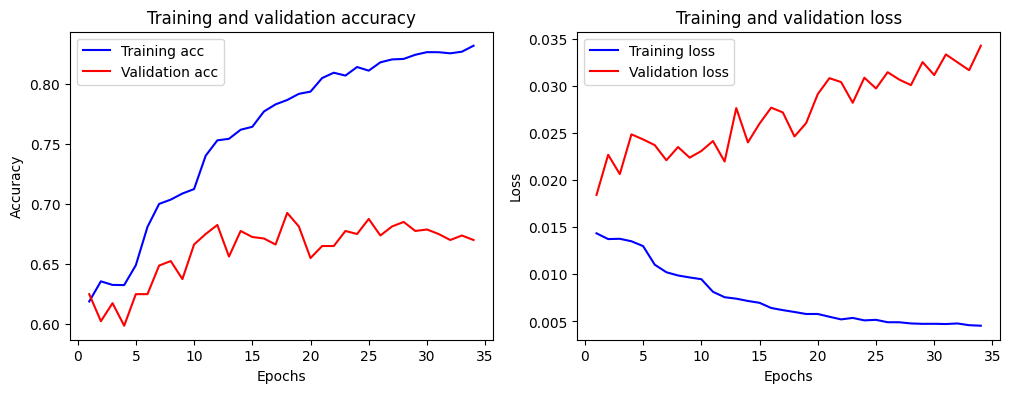

In [95]:
plot_training_history("",train_acc_history, val_acc_history, train_loss_history, val_loss_history)

In [104]:
torch.cuda.empty_cache() 


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
efficientnet_model = EfficientNetModel().to(device)
efficientnet_model.load_state_dict(torch.load("/kaggle/working/efficientnet.pt"))

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

<All keys matched successfully>

In [106]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"

result = evaluate(efficientnet_model, test_loader)
    
# result = {
#                 "accuracy":accuracy.cpu().numpy().item(),
#                 "recall":recall,
#                 "precision":precision,
#                 "auc_ovo":auc_ovo,
#                 "auc_ovr":auc_ovr,
#                 "test_preds":test_preds,
#                 "test_targets":test_targets}

    
with open("/kaggle/working/result.json", "w") as outfile: 
    json.dump(result, outfile)

Accuracy: 0.6700, Recall: 0.6700, Precision: 0.7333,f1 score: 0.6741, One-vs-One ROC AUC: 0.9450, One-vs-Rest ROC AUC: 0.9450


In [107]:
import seaborn as sns

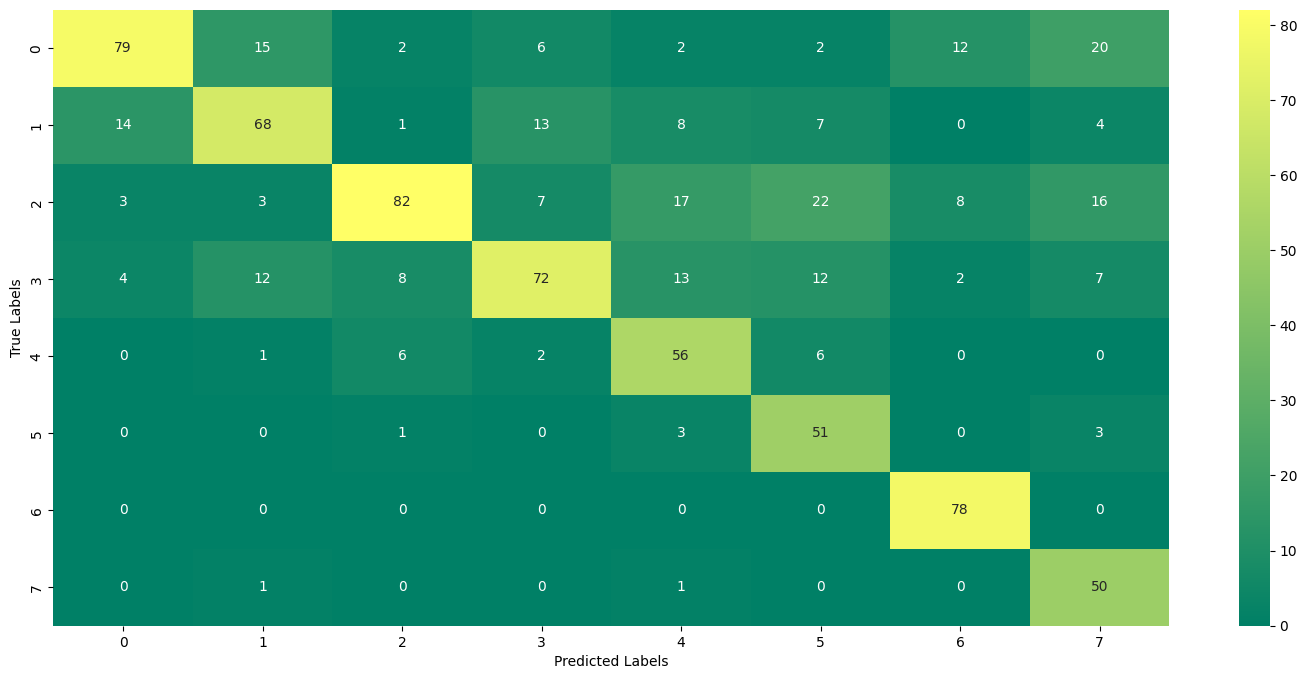

<Figure size 640x480 with 0 Axes>

In [108]:
y_pred = pd.Series(result['test_preds'])
y_test = pd.Series(result['test_targets'])
plt.figure(figsize = (18,8))
sns.heatmap(confusion_matrix(y_test, y_pred), annot = True, xticklabels = mapping.values(), yticklabels = mapping.values(), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
plt.savefig('confusion.png')